In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, distinct, extract, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Msrm = Base.classes.measurement
Stat = Base.classes.station

In [8]:
#Get a list of column names and types - Measurement
inspector = inspect(engine)
msrm_columns = inspector.get_columns('measurement')
for r in msrm_columns:
    print(r['name'], r['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Get a list of column names and types - Station
stat_columns = inspector.get_columns('station')
for r in stat_columns:
    print(r['name'], r['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
#View Head of the data
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
# Find the most recent date in the data set.
min_date = session.query(Msrm.date).order_by(Msrm.date).first()
min_date

('2010-01-01')

In [13]:
# Find the last date in the data set.
max_date = session.query(Msrm.date).order_by(Msrm.date.desc()).first()
max_date

('2017-08-23')

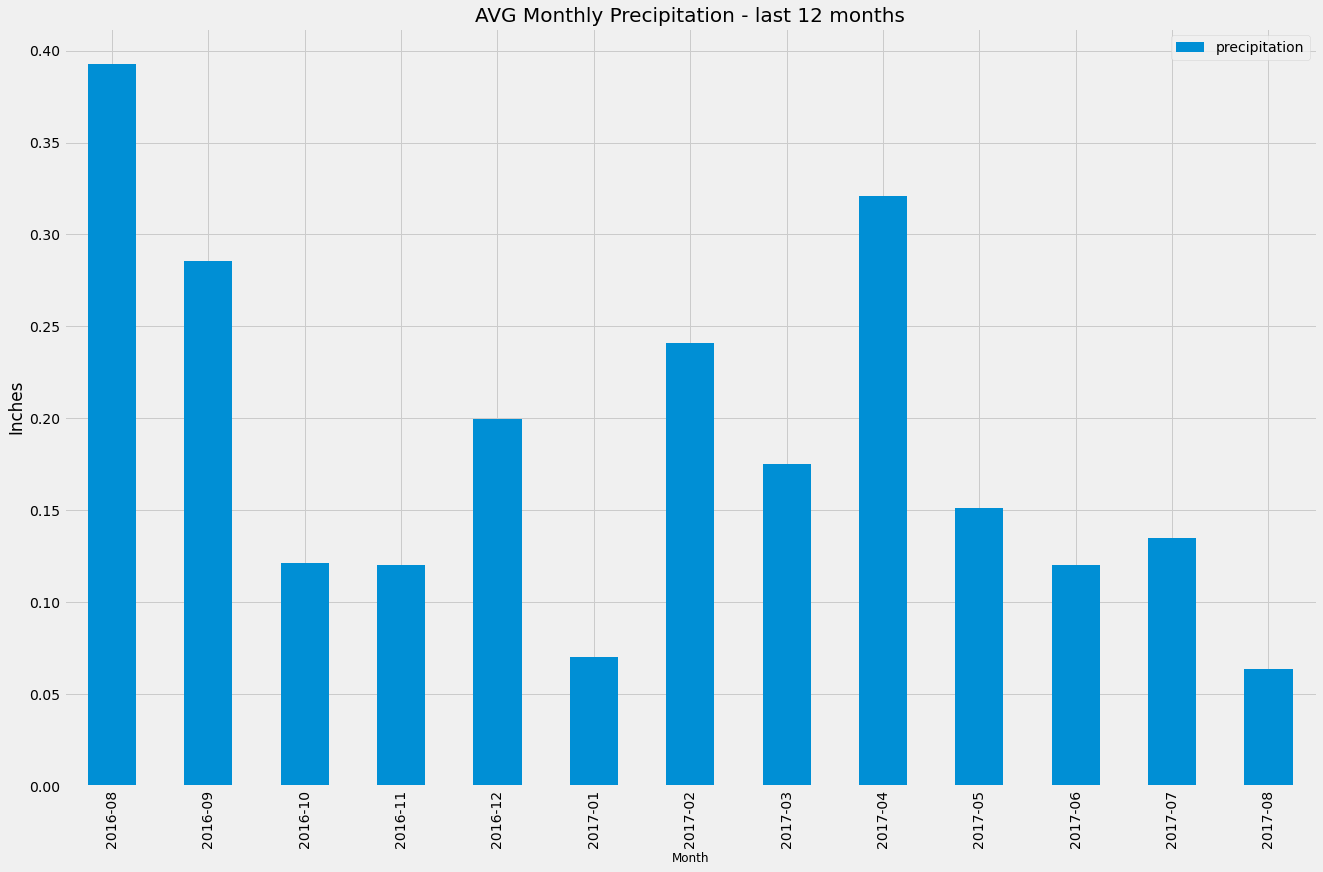

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcp_l12m = engine.execute('''SELECT date, prcp FROM measurement 
                WHERE date >= ( 
                SELECT DATE(max(date), "-12 months")
                FROM measurement)
                ''').fetchall()

#In order to have a better visualization trunc dates to months

mont_prcp_l12m = engine.execute('''SELECT strftime("%Y-%m",date), AVG(prcp) FROM measurement 
                WHERE date >= ( 
                SELECT DATE(max(date), "-12 months")
                FROM measurement)
                GROUP BY 1
                ''').fetchall()


df = pd.DataFrame(mont_prcp_l12m, columns = ['date', 'precipitation'])
df.set_index('date', inplace = True)
df.plot.bar(figsize = (20, 13))
plt.title('AVG Monthly Precipitation - last 12 months', fontsize = 20)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Inches')
plt.show()





In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df = pd.DataFrame(prcp_l12m, columns = ['date', 'precipitation'])
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Stat.station)).all()

[(9)]

In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Msrm.station, func.count(Msrm.id)). \
    group_by(Msrm.station). \
    order_by(func.count(Msrm.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Msrm.station, func.min(Msrm.tobs), func.max(Msrm.tobs), func.avg(Msrm.tobs)). \
    filter(Msrm.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

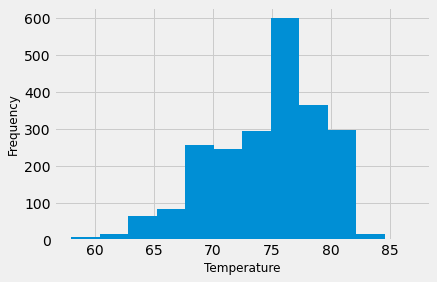

In [85]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = engine.execute('''SELECT tobs FROM measurement 
                WHERE date >= ( 
                SELECT DATE(max(date), "-12 months")
                FROM measurement
                WHERE station = "USC00519281")
                ''').fetchall()

tobs_df = pd.DataFrame(tobs, columns = ['tobs'])
plt.hist(tobs_df, bins=12)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Frequency', fontsize=12)



# Close session

In [86]:
# Close Session
session.close()